# Mobile Phone Price Prediction using Machine Learning

## Step 1: Importing Required Libraries and Models


In [62]:
# ============================
# Import Required Libraries
# ============================

# Data Handling
import pandas as pd
import numpy as np

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt

# Machine Learning Models
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
import re

# Preprocessing & Utilities
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Evaluation Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt

# Tabular Results
from tabulate import tabulate

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


## Step 2: Data Collection 

In [63]:
data = pd.read_csv('mobiles_dataset_2025.csv', encoding='latin1')
data = data.sample(frac=1, random_state=42).reset_index(drop=True)  # Shuffle the dataset

## Step 3: Data Preprocessing

In [64]:
# Check for null value
data.isnull().sum()

Company Name            0
Model Name              0
Mobile Weight           0
RAM                     0
Front Camera            0
Back Camera             0
Processor               0
Battery Capacity        0
Screen Size             0
Launched Price (USA)    0
Launched Year           0
dtype: int64

In [65]:
# Helper function to clean numeric columns
def clean_numeric(series, remove_str="", round_to_int=False):
    cleaned = (
        series.astype(str)
        .str.replace(remove_str, "", regex=False)
        .str.replace("Not available", "", regex=False)
        .str.replace(",", "", regex=False)
        .str.extract(r"(\d+\.?\d*)")[0]   
    )
    cleaned = pd.to_numeric(cleaned, errors="coerce")
    
    if round_to_int:
        cleaned = cleaned.round().astype("Int64")  
    return cleaned

def extract_rom(model_name):
    model_name = str(model_name).upper()
    match_tb = re.search(r'(\d+)TB', model_name)
    if match_tb:
        return float(match_tb.group(1)) 
    match_gb = re.search(r'(\d+)GB', model_name)
    if match_gb:
        return float(match_gb.group(1)) / 1024
    return np.nan

print("Columns:", data.columns.tolist())

# RAM
if "RAM" in data.columns:
    data["RAM"] = clean_numeric(data["RAM"], remove_str="GB", round_to_int=True) / 4

# ROM
data['ROM'] = data['Model Name'].apply(extract_rom).apply(lambda x: x if not pd.isna(x) else np.nan)

data['ROM'] = data['ROM'].astype('Float64')
data['ROM'] = data['ROM'].fillna(data['ROM'].median())

# Front Camera
if "Front Camera" in data.columns:
    data["Front Camera"] = clean_numeric(data["Front Camera"], remove_str="MP") / 10

# Back Camera
if "Back Camera" in data.columns:
    data["Back Camera"] = clean_numeric(data["Back Camera"], remove_str="MP") / 10

# Rear / Primary Camera (handle whichever exists)
for cam_col in ["Primary Camera", "Rear Camera", "Main Camera"]:
    if cam_col in data.columns:
        data[cam_col] = clean_numeric(data[cam_col], remove_str="MP")

# Battery
if "Battery Capacity" in data.columns:
    data["Battery Capacity"] = clean_numeric(data["Battery Capacity"], remove_str="mAh", round_to_int=True)
    data["Battery Capacity"] = data["Battery Capacity"] / 1000
if "Internal Storage" in data.columns:
    data["Internal Storage"] = clean_numeric(data["Internal Storage"], remove_str="GB", round_to_int=True)

# Weight
if "Mobile Weight" in data.columns:
    data["Mobile Weight"] = clean_numeric(data["Mobile Weight"], remove_str="g", round_to_int=True) / 100

# Screen Size
if "Screen Size" in data.columns:
    data["Screen Size"] = clean_numeric(data["Screen Size"], remove_str="inches")

# Price cleaning
def clean_usa_price(price_str):
    if pd.isna(price_str):
        return np.nan
    
    price_str = str(price_str).strip()
    price_str = price_str.replace("USD", "").replace("$", "").strip()
    price_str = price_str.replace(" ", "")
    
    if price_str in ["", "Not available", "not available", "N/A", "None"]:
        return np.nan
    
    try:
        comma_count = price_str.count(',')
        
        if comma_count == 0:
            return float(price_str)
        elif comma_count == 1:
            comma_pos = price_str.index(',')
            digits_after = len(price_str) - comma_pos - 1
            
            if digits_after == 2:
                price_str = price_str.replace(',', '.')
            else:
                price_str = price_str.replace(',', '')
        else:
            price_str = price_str.replace(',', '')
        
        value = float(price_str)
        
        if 99 <= value <= 2000:
            return value
        else:
            return np.nan 
    except:
        return np.nan

# Clean Launch price USA
if "Launched Price (USA)" in data.columns:
    print("Cleaning USA prices...")
    print(f"Before: {data['Launched Price (USA)'].head(10).tolist()}")

    data["Launched Price (USA)"] = data["Launched Price (USA)"].apply(clean_usa_price)

    print(f"After: {data['Launched Price (USA)'].head(10).tolist()}")
    print(f"\nUSA Price Statistics:")
    print(data["Launched Price (USA)"].describe())
    print(f"\nInvalid/Placeholder values: {data['Launched Price (USA)'].isna().sum()}")

print("\n" + "="*60)
print("NUMERIC FEATURES CLEANED")
print("="*60)

Columns: ['Company Name', 'Model Name', 'Mobile Weight', 'RAM', 'Front Camera', 'Back Camera', 'Processor', 'Battery Capacity', 'Screen Size', 'Launched Price (USA)', 'Launched Year']
Cleaning USA prices...
Before: ['USD 379', 'USD 139', 'USD 1,099', 'USD 549', 'USD 749', 'USD 699', 'USD 799', 'USD 230', 'USD 360', 'USD 199']
After: [379.0, 139.0, 1099.0, 549.0, 749.0, 699.0, 799.0, 230.0, 360.0, 199.0]

USA Price Statistics:
count     923.000000
mean      568.419155
std       385.744473
min        79.000000
25%       250.000000
50%       449.000000
75%       799.000000
max      1899.000000
Name: Launched Price (USA), dtype: float64

Invalid/Placeholder values: 7

NUMERIC FEATURES CLEANED


### K-Fold Target Encoding for Categorical Features

Thay vì One-Hot Encoding và TF-IDF/PCA, chúng ta sử dụng **K-Fold Target Encoding** với các ưu điểm:
- ✅ Không data leakage (K-Fold cross-validation)
- ✅ Xử lý chip/company hiếm (smoothing)
- ✅ Tối ưu cho Random Forest (không cần normalize)
- ✅ Giảm số chiều features

In [66]:
from target_encoder import KFoldTargetEncoder

# Simplify Company Names
if 'Company Name' in data.columns:
    company_counts = data['Company Name'].value_counts()
    top_companies = company_counts.head(5).index.tolist()
    
    data['Company'] = data['Company Name'].apply(
        lambda x: x if x in top_companies else 'Other'
    )
    
    print(f"Company categories: {data['Company'].nunique()}")
    print(data['Company'].value_counts())

# Keep Processor as-is
if 'Processor' in data.columns:
    data['Processor'] = data['Processor'].fillna('Unknown')
    
    print(f"\nProcessor categories: {data['Processor'].nunique()}")
    print(f"Top 10 processors:")
    print(data['Processor'].value_counts().head(10))

# Initialize K-Fold Target Encoder
encoder = KFoldTargetEncoder(
    columns=['Company', 'Processor'],
    n_splits=5,
    smoothing=10,
    random_state=42
)

print("\n" + "="*60)
print("K-Fold Target Encoder initialized")
print(f"Columns to encode: {encoder.columns}")
print(f"K-Folds: {encoder.n_splits}")
print(f"Smoothing: {encoder.smoothing}")
print("="*60)

Company categories: 6
Company
Other      439
Oppo       129
Apple       97
Honor       91
Samsung     88
Vivo        86
Name: count, dtype: int64

Processor categories: 217
Top 10 processors:
Processor
Snapdragon 8 Gen 2         30
MediaTek Dimensity 810     22
MediaTek Helio G99         21
Snapdragon 8 Gen 3         19
MediaTek Helio G85         19
A15 Bionic                 18
A16 Bionic                 18
Qualcomm Snapdragon 695    16
Snapdragon 8 Gen 1         16
MediaTek Dimensity 700     15
Name: count, dtype: int64

K-Fold Target Encoder initialized
Columns to encode: ['Company', 'Processor']
K-Folds: 5
Smoothing: 10


In [67]:
# Remove rows with missing target
data = data.dropna(subset=['Launched Price (USA)'])

# Prepare features and target
# IMPORTANT: Scale down price by 100 to reduce magnitude difference
y = data['Launched Price (USA)'] / 100  # Scale price to 0-20 range instead of 0-2000
X = data[['Company', 'Processor']].copy()

print(f"Target (price) range after scaling:")
print(f"  Min: ${y.min():.2f} (original: ${y.min()*100:.2f})")
print(f"  Max: ${y.max():.2f} (original: ${y.max()*100:.2f})")
print(f"  Mean: ${y.mean():.2f} (original: ${y.mean()*100:.2f})")

# Fit encoder on full dataset and transform
encoder.fit(X, y)

# Transform using fitted encodings (for full dataset preprocessing)
X_encoded = encoder.transform(X)

print("\n" + "="*60)
print("ENCODING COMPLETE")
print("="*60)
print(f"Original features: {X.columns.tolist()}")
print(f"Encoded features: {X_encoded.columns.tolist()}")

# Add encoded features back to data
data['Company_encoded'] = X_encoded['Company_encoded'].values
data['Processor_encoded'] = X_encoded['Processor_encoded'].values

# Show encoding statistics
print("\n" + "-"*60)
print("COMPANY ENCODING STATISTICS (scaled /100)")
print("-"*60)
company_stats = encoder.get_encoding_stats(X, 'Company')
print(company_stats)

print("\n" + "-"*60)
print("PROCESSOR ENCODING STATISTICS (Top 15, scaled /100)")
print("-"*60)
processor_stats = encoder.get_encoding_stats(X, 'Processor')
print(processor_stats.head(15))

Target (price) range after scaling:
  Min: $0.79 (original: $79.00)
  Max: $18.99 (original: $1899.00)
  Mean: $5.68 (original: $568.42)



ENCODING COMPLETE
Original features: ['Company', 'Processor']
Encoded features: ['Company_encoded', 'Processor_encoded']

------------------------------------------------------------
COMPANY ENCODING STATISTICS (scaled /100)
------------------------------------------------------------
  category  encoded_value  count
0    Apple       9.854878     97
4  Samsung       7.143009     87
1    Honor       6.036950     91
2     Oppo       5.098215    129
5     Vivo       4.797728     86
3    Other       4.652936    433

------------------------------------------------------------
PROCESSOR ENCODING STATISTICS (Top 15, scaled /100)
------------------------------------------------------------
                        category  encoded_value  count
6                     A16 Bionic       9.362926     18
192           Snapdragon 8 Gen 2       9.301048     30
193           Snapdragon 8 Gen 3       9.298640     18
2                    A12Z Bionic       9.034853     11
143  Qualcomm Snapdragon 8 Gen 3

### Export Processed Data for Modeling

Xuất dữ liệu đã xử lý (bao gồm Target Encoding) ra file CSV để sử dụng trong modeling notebook.

In [68]:
# Select features for modeling
# NOTE: Excluded 'Launched Year' and 'Mobile Weight' as requested
numeric_features = [
    'RAM', 'ROM', 'Battery Capacity', 
    'Front Camera', 'Back Camera', 'Screen Size'
]

encoded_features = ['Company_encoded', 'Processor_encoded']
target = ['Launched Price (USA)']

# Combine all features
all_features = numeric_features + encoded_features + target

# Filter features that exist in data
available_features = [f for f in all_features if f in data.columns]

# Create final dataset
data_processed = data[available_features].copy()

# NORMALIZE PRICE: Divide by 100 to scale to 0-20 range
print("="*60)
print("NORMALIZING TARGET VARIABLE")
print("="*60)
print(f"Original price range: ${data_processed['Launched Price (USA)'].min():.2f} - ${data_processed['Launched Price (USA)'].max():.2f}")
data_processed['Launched Price (USA)'] = data_processed['Launched Price (USA)'] / 100
print(f"Normalized price range: ${data_processed['Launched Price (USA)'].min():.2f} - ${data_processed['Launched Price (USA)'].max():.2f}")
print("(Scaled by /100 for better model convergence)")

# Remove any remaining NaN values
data_processed = data_processed.dropna()

print("\n" + "="*60)
print("FINAL PROCESSED DATASET")
print("="*60)
print(f"Shape: {data_processed.shape}")
print(f"\nFeatures included:")
for i, col in enumerate(data_processed.columns, 1):
    print(f"  {i}. {col}")

print(f"\nExcluded features:")
print(f"  - Launched Year (temporal feature, removed)")
print(f"  - Mobile Weight (removed as requested)")

print(f"\nData types:")
print(data_processed.dtypes)

print(f"\nFirst 5 rows:")
print(data_processed.head())

print(f"\nStatistics:")
print(data_processed.describe())

print("\n" + "-"*60)
print("ENCODED FEATURES RANGE (after /100 scaling):")
print("-"*60)
print(f"Company_encoded:   {data_processed['Company_encoded'].min():.2f} to {data_processed['Company_encoded'].max():.2f}")
print(f"Processor_encoded: {data_processed['Processor_encoded'].min():.2f} to {data_processed['Processor_encoded'].max():.2f}")
print(f"Price (normalized): {data_processed['Launched Price (USA)'].min():.2f} to {data_processed['Launched Price (USA)'].max():.2f}")
print(f"\nOther features range:")
print(f"RAM:              {data_processed['RAM'].min():.2f} to {data_processed['RAM'].max():.2f}")
print(f"ROM:              {data_processed['ROM'].min():.4f} to {data_processed['ROM'].max():.4f}")
print(f"Battery Capacity: {data_processed['Battery Capacity'].min():.2f} to {data_processed['Battery Capacity'].max():.2f}")

# Export to CSV
output_file = 'mobiles_dataset_2025_processed.csv'
data_processed.to_csv(output_file, index=False)

print("\n" + "="*60)
print(f"✅ Exported to: {output_file}")
print("="*60)
print(f"This file is ready for use in modeling_knn_dt_rf_nn.ipynb")
print(f"\nIMPORTANT NOTES:")
print(f"  - Target encoding values scaled by /100")
print(f"  - Price normalized by /100 (range: 0.79 - 18.99)")
print(f"  - To get original price: multiply prediction by 100")

NORMALIZING TARGET VARIABLE
Original price range: $79.00 - $1899.00
Normalized price range: $0.79 - $18.99
(Scaled by /100 for better model convergence)

FINAL PROCESSED DATASET
Shape: (923, 9)

Features included:
  1. RAM
  2. ROM
  3. Battery Capacity
  4. Front Camera
  5. Back Camera
  6. Screen Size
  7. Company_encoded
  8. Processor_encoded
  9. Launched Price (USA)

Excluded features:
  - Launched Year (temporal feature, removed)
  - Mobile Weight (removed as requested)

Data types:
RAM                     Float64
ROM                     Float64
Battery Capacity        Float64
Front Camera            float64
Back Camera             float64
Screen Size             float64
Company_encoded         float64
Processor_encoded       float64
Launched Price (USA)    float64
dtype: object

First 5 rows:
    RAM     ROM  Battery Capacity  Front Camera  Back Camera  Screen Size  \
0   3.0   0.125               5.3           3.2         10.8         6.90   
1  0.75  0.0625               5.0

In [69]:
# Save encoder for inference
import pickle

with open('target_encoder_fitted.pkl', 'wb') as f:
    pickle.dump(encoder, f)

print("✅ Saved fitted encoder: target_encoder_fitted.pkl")
print("\nThis encoder can be used for predicting new phone prices.")

✅ Saved fitted encoder: target_encoder_fitted.pkl

This encoder can be used for predicting new phone prices.


In [70]:
data.describe()

,Mobile Weight,RAM,Front Camera,Back Camera,Battery Capacity,Screen Size,Launched Price (USA),Launched Year,ROM,Company_encoded,Processor_encoded
count,923.0,923.0,923.000000,923.000000,923.0,923.000000,923.000000,923.000000,923.0,923.000000,923.000000
mean,2.280921,1.940683,1.821549,4.673976,5.02842,7.077909,568.419155,2022.186349,0.193239,5.646504,5.858251
std,1.057996,0.793609,1.201408,3.118634,1.360302,1.537967,385.744473,1.864716,0.139576,1.631710,1.657770
min,1.35,0.25,0.200000,0.500000,2.0,5.000000,79.000000,2014.000000,0.015625,4.652936,3.152480
25%,1.85,1.5,0.800000,1.300000,4.4,6.500000,250.000000,2021.000000,0.125,4.652936,4.851370
50%,1.94,2.0,1.600000,5.000000,5.0,6.670000,449.000000,2023.000000,0.125,4.797728,5.360160
75%,2.07,2.0,3.200000,5.000000,5.1,6.780000,799.000000,2024.000000,0.25,6.036950,6.919146
max,7.32,4.0,6.000000,20.000000,11.2,14.600000,1899.000000,2025.000000,2.0,9.854878,9.362926


In [71]:
# Remove the duplicate values
data.drop_duplicates(inplace=True)
data.shape
data.head()

,Company Name,Model Name,Mobile Weight,RAM,Front Camera,Back Camera,Processor,Battery Capacity,Screen Size,Launched Price (USA),Launched Year,ROM,Company,Company_encoded,Processor_encoded
0,Infinix,Hot 50 Pro+,1.96,3.0,3.2,10.8,MediaTek Dimensity 9200,5.3,6.90,379.0,2024,0.125,Other,4.652936,6.907234
1,Nokia,C32 64GB,1.99,0.75,0.8,5.0,Unisoc SC9863A,5.0,6.52,139.0,2023,0.0625,Other,4.652936,3.714551
2,Apple,iPhone 14 Pro 128GB,2.06,1.5,1.2,4.8,A16 Bionic,4.2,6.10,1099.0,2022,0.125,Apple,9.854878,9.362926
3,Oppo,Reno8 Pro 5G 256GB,1.83,3.0,3.2,5.0,Dimensity 8100,4.5,6.70,549.0,2022,0.25,Oppo,5.098215,5.716301
4,OnePlus,OnePlus 10T 256GB,2.03,3.0,1.6,5.0,Snapdragon 8+ Gen 1,4.5,6.70,749.0,2022,0.25,Other,4.652936,6.850996


## Step 4: Initial Data Exploration & Visualization

In [72]:
data.describe()

,Mobile Weight,RAM,Front Camera,Back Camera,Battery Capacity,Screen Size,Launched Price (USA),Launched Year,ROM,Company_encoded,Processor_encoded
count,908.0,908.0,908.000000,908.000000,908.0,908.000000,908.000000,908.000000,908.0,908.000000,908.000000
mean,2.287412,1.94163,1.822015,4.646454,5.032607,7.086762,573.706916,2022.198238,0.193747,5.656052,5.880307
std,1.065422,0.796583,1.207207,3.124252,1.370439,1.549013,386.605655,1.871953,0.14043,1.643378,1.660982
min,1.35,0.25,0.200000,0.500000,2.0,5.000000,79.000000,2014.000000,0.015625,4.652936,3.152480
25%,1.85,1.5,0.800000,1.300000,4.4,6.500000,266.750000,2021.000000,0.125,4.652936,4.885160
50%,1.94,2.0,1.600000,5.000000,5.0,6.670000,449.000000,2023.000000,0.125,4.797728,5.375629
75%,2.08,2.0,3.200000,5.000000,5.1,6.780000,811.500000,2024.000000,0.25,6.036950,6.923870
max,7.32,4.0,6.000000,20.000000,11.2,14.600000,1899.000000,2025.000000,2.0,9.854878,9.362926


Hệ số tương quan giữa năm ra mắt và giá ra mắt (USA): 0.034
    Launched Year  Launched Price (USA)
0            2014            169.000000
1            2016            211.000000
2            2017            505.666667
3            2018            630.904762
4            2019            609.434783
5            2020            585.326531
6            2021            501.372549
7            2022            580.677379
8            2023            590.939227
9            2024            588.483136
10           2025            428.666667


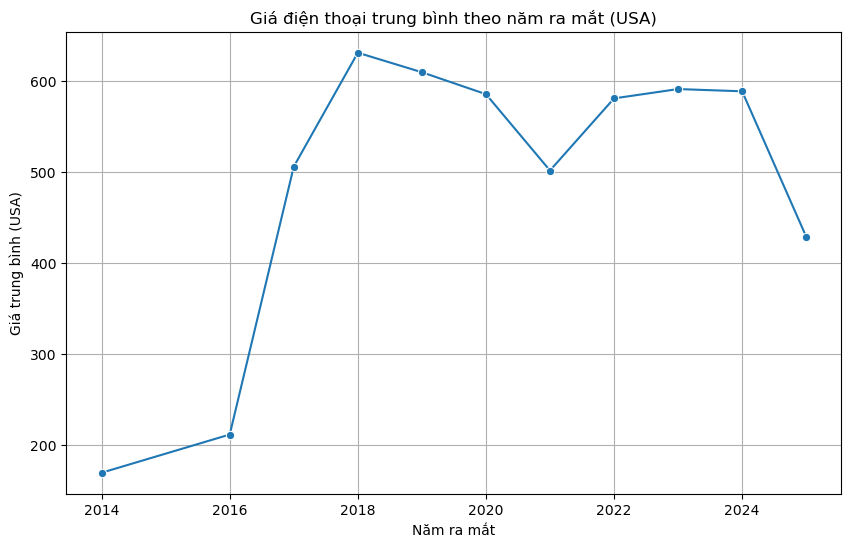

In [73]:
# Loại bỏ giá trị thiếu
df_filtered = data[['Launched Year', 'Launched Price (USA)']].dropna()

# Tính hệ số tương quan Pearson
correlation = df_filtered['Launched Year'].corr(df_filtered['Launched Price (USA)'])
print(f"Hệ số tương quan giữa năm ra mắt và giá ra mắt (USA): {correlation:.3f}")

# Tạo bảng trung bình giá theo năm ra mắt
summary = df_filtered.groupby('Launched Year')['Launched Price (USA)'].mean().reset_index()
print(summary)

# Vẽ biểu đồ
plt.figure(figsize=(10, 6))
sns.lineplot(data=summary, x='Launched Year', y='Launched Price (USA)', marker='o')
plt.title('Giá điện thoại trung bình theo năm ra mắt (USA)')
plt.xlabel('Năm ra mắt')
plt.ylabel('Giá trung bình (USA)')
plt.grid(True)
plt.show()

In [74]:
# DEPRECATED: This cell used One-Hot Encoding + TF-IDF/PCA
# Now we use K-Fold Target Encoding (see cells above)
# This cell is kept for reference only

# Old approach (commented out):
# from sklearn.preprocessing import StandardScaler
# from sklearn.compose import ColumnTransformer
# numeric_features = [
#     'RAM', 'ROM', 'Mobile Weight', 'Battery Capacity', 
#     'Front Camera', 'Back Camera', 'Launched Year'
# ]
# passthrough_features = [
#     'Launched Price (USA)',
#     'Company_Apple','Company_Honor', 'Company_Oppo', 'Company_Other', 'Company_Samsung',
#     'Company_Vivo', 'Processor_vec1', 'Processor_vec2', 'Processor_vec3'
# ]

# NEW APPROACH: Using Target Encoding
# See the cells above with K-Fold Target Encoding
# Output file: mobiles_dataset_2025_processed.csv

print("⚠️ This cell is deprecated!")
print("✅ Use the Target Encoding approach above instead")
print("✅ Processed data saved to: mobiles_dataset_2025_processed.csv")

⚠️ This cell is deprecated!
✅ Use the Target Encoding approach above instead
✅ Processed data saved to: mobiles_dataset_2025_processed.csv


In [75]:
# DEPRECATED: Correlation heatmap for old encoding method
# Use the processed CSV file for modeling instead

print("⚠️ This cell is deprecated!")
print("✅ Use mobiles_dataset_2025_processed.csv for modeling")
print("✅ See modeling_knn_dt_rf_nn.ipynb for updated workflow")

⚠️ This cell is deprecated!
✅ Use mobiles_dataset_2025_processed.csv for modeling
✅ See modeling_knn_dt_rf_nn.ipynb for updated workflow


In [76]:
# DEPRECATED: Old pipeline with One-Hot Encoding
print("⚠️ This cell is deprecated!")
print("✅ Use mobiles_dataset_2025_processed.csv with Target Encoding")

⚠️ This cell is deprecated!
✅ Use mobiles_dataset_2025_processed.csv with Target Encoding


In [77]:
# DEPRECATED: Old training code with One-Hot Encoding
print("⚠️ This cell is deprecated!")
print("✅ Use mobiles_dataset_2025_processed.csv for modeling")
print("✅ See modeling_knn_dt_rf_nn.ipynb or train_with_target_encoding.py")

⚠️ This cell is deprecated!
✅ Use mobiles_dataset_2025_processed.csv for modeling
✅ See modeling_knn_dt_rf_nn.ipynb or train_with_target_encoding.py


In [78]:
# DEPRECATED: Old model fitting
print("⚠️ This cell is deprecated!")
print("✅ Use the new Target Encoding workflow")

⚠️ This cell is deprecated!
✅ Use the new Target Encoding workflow


In [79]:
# DEPRECATED: Old preprocessor saving (TF-IDF + PCA)
# Now using K-Fold Target Encoder (saved as target_encoder_fitted.pkl)

print("⚠️ This cell is deprecated!")
print("✅ Encoder saved to: target_encoder_fitted.pkl")
print("✅ Use target_encoder_fitted.pkl for new predictions")

⚠️ This cell is deprecated!
✅ Encoder saved to: target_encoder_fitted.pkl
✅ Use target_encoder_fitted.pkl for new predictions
